Part One: Preprocessing Code

In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load data
df = pd.read_csv("/content/Loan payments data.csv")


# Construct target label
df["loan_status_binary"] = (df["loan_status"] != "PAIDOFF").astype(int)


# Handle datetime fields
df["effective_date"] = pd.to_datetime(df["effective_date"])
df["due_date"] = pd.to_datetime(df["due_date"])


# safe derived feature:
df["loan_duration_days"] = (df["due_date"] - df["effective_date"]).dt.days


# Select SAFE features only (remove leakage)
numeric_cols = ["Principal", "terms", "age", "loan_duration_days"]
categorical_cols = ["education", "Gender"]

X_raw = df[numeric_cols + categorical_cols]
y = df["loan_status_binary"]


# One-Hot encoding for categorical vars
X_cat = pd.get_dummies(X_raw[categorical_cols], drop_first=True)
X_num = X_raw[numeric_cols]

X_processed = pd.concat([X_num, X_cat], axis=1)



# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)



# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)



# Build DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



# pos_weight for imbalanced classification
pos_count = y_train.sum().item()
neg_count = len(y_train) - pos_count
pos_weight = torch.tensor([neg_count / pos_count])

print("Preprocessing done.")


Preprocessing done.


Part II: MLP with Switchable Activation Functions

In [2]:
import torch.nn as nn

# Return corresponding activation function layer based on string name
def get_activation(name):
    name = name.lower()
    if name == "linear":
        return nn.Identity()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "relu":
        return nn.ReLU()
    elif name == "leaky_relu":
        return nn.LeakyReLU(0.01)
    else:
        raise ValueError(f"Unknown activation: {name}")

# Multi-Layer Perceptron model for loan prediction
class LoanMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], activation="relu"):
        super().__init__()
        act = get_activation(activation)

        layers = []
        in_dim = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(act)
            in_dim = h

        layers.append(nn.Linear(in_dim, 1))  # output logit
        self.net = nn.Sequential(*layers)

    def forward(self, x):
       # Forward pass through the network
        return self.net(x).view(-1)


Part III: Training and Validation Functions

In [3]:
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Train model for one epoch to get average training loss for the epoch
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total = 0
    running_loss = 0.0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * Xb.size(0)

    return running_loss / len(loader.dataset)


# Evaluate model performance on a dataset
def evaluate(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)

            all_logits.append(logits.cpu())
            all_labels.append(yb)

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    auc = roc_auc_score(labels, probs)

    return acc, f1, auc


Part IV: Training All Activation Functions

In [4]:
# Train multiple models with different activation functions
def train_all_models(activations, num_epochs=30, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train.shape[1]

    results = {}
    models = {}

    for act in activations:
        print(f"\nTraining activation = {act}")

        model = LoanMLP(input_dim, activation=act).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        history = {"train_loss": [], "acc": [], "f1": [], "auc": []}

        for epoch in range(num_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, device)
            acc, f1, auc = evaluate(model, val_loader, device)

            history["train_loss"].append(train_loss)
            history["acc"].append(acc)
            history["f1"].append(f1)
            history["auc"].append(auc)

            print(f"Epoch {epoch+1}: loss={train_loss:.4f}, acc={acc:.3f}, f1={f1:.3f}, auc={auc:.3f}")

        results[act] = history
        models[act] = model

    return results, models


In [5]:
activations = ["linear", "sigmoid", "relu", "leaky_relu"]
results, models = train_all_models(activations)



Training activation = linear
Epoch 1: loss=0.8272, acc=0.590, f1=0.423, auc=0.537
Epoch 2: loss=0.8177, acc=0.580, f1=0.488, auc=0.562
Epoch 3: loss=0.8186, acc=0.570, f1=0.482, auc=0.568
Epoch 4: loss=0.8183, acc=0.560, f1=0.488, auc=0.569
Epoch 5: loss=0.8176, acc=0.570, f1=0.506, auc=0.559
Epoch 6: loss=0.8167, acc=0.560, f1=0.500, auc=0.555
Epoch 7: loss=0.8176, acc=0.550, f1=0.483, auc=0.545
Epoch 8: loss=0.8165, acc=0.580, f1=0.462, auc=0.551
Epoch 9: loss=0.8167, acc=0.570, f1=0.427, auc=0.552
Epoch 10: loss=0.8162, acc=0.560, f1=0.488, auc=0.546
Epoch 11: loss=0.8169, acc=0.550, f1=0.483, auc=0.541
Epoch 12: loss=0.8166, acc=0.550, f1=0.483, auc=0.551
Epoch 13: loss=0.8164, acc=0.550, f1=0.483, auc=0.550
Epoch 14: loss=0.8166, acc=0.530, f1=0.434, auc=0.549
Epoch 15: loss=0.8165, acc=0.530, f1=0.472, auc=0.553
Epoch 16: loss=0.8165, acc=0.550, f1=0.483, auc=0.555
Epoch 17: loss=0.8166, acc=0.550, f1=0.483, auc=0.558
Epoch 18: loss=0.8170, acc=0.550, f1=0.483, auc=0.547
Epoch 1

Part V: Plot the Loss and AUC Curves

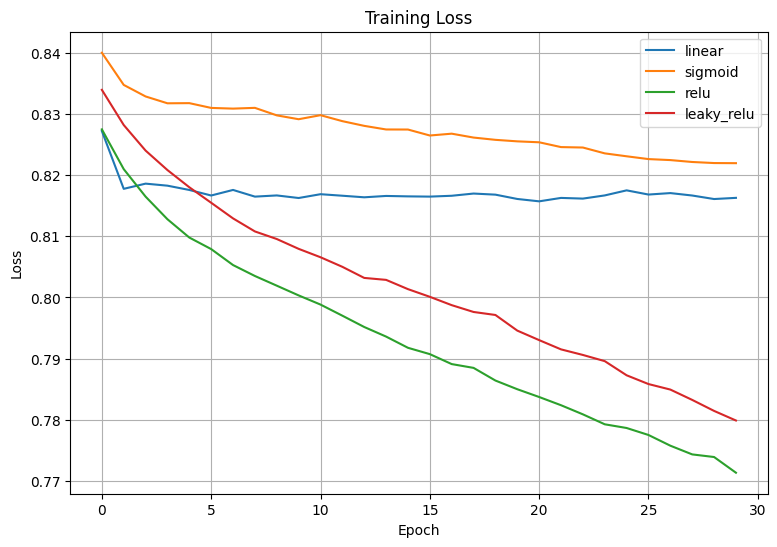

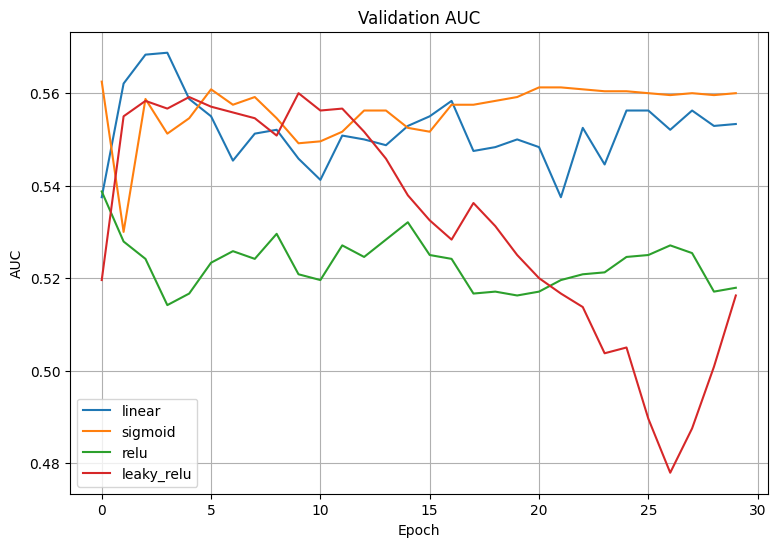

In [6]:
import matplotlib.pyplot as plt

# Plot training loss curves for different activation functions
def plot_loss_curves(results):
    plt.figure(figsize=(9,6))
    for act in results:
        plt.plot(results[act]["train_loss"], label=act)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Plot validation AUC curves for different activation functions
def plot_auc_curves(results):
    plt.figure(figsize=(9,6))
    for act in results:
        plt.plot(results[act]["auc"], label=act)
    plt.title("Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(results)
plot_auc_curves(results)



Part VI: Plot histograms for four activation functions


Plotting probability histogram for activation: linear


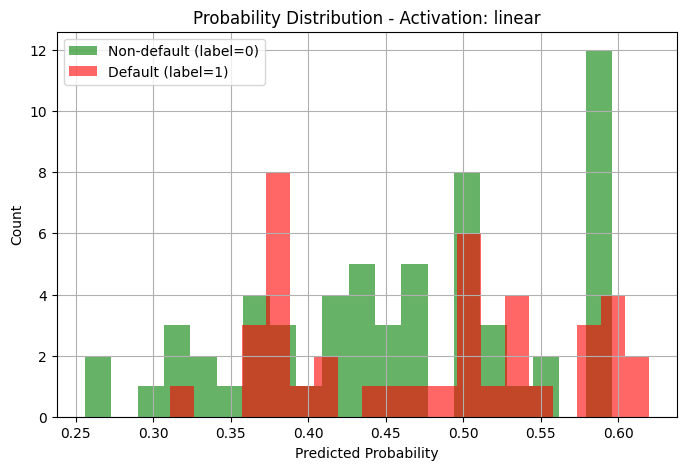


Plotting probability histogram for activation: sigmoid


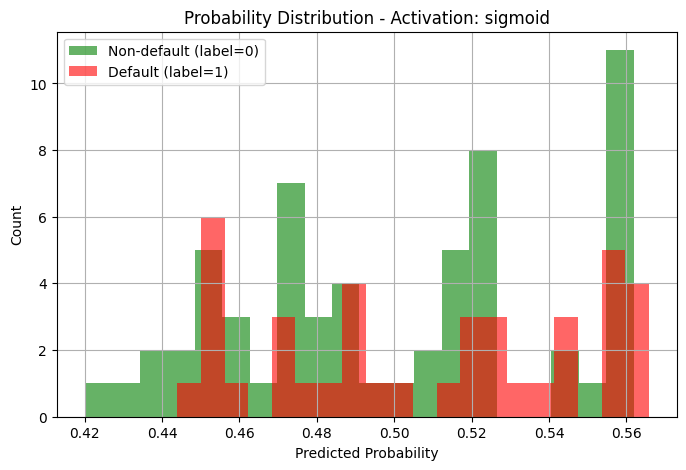


Plotting probability histogram for activation: relu


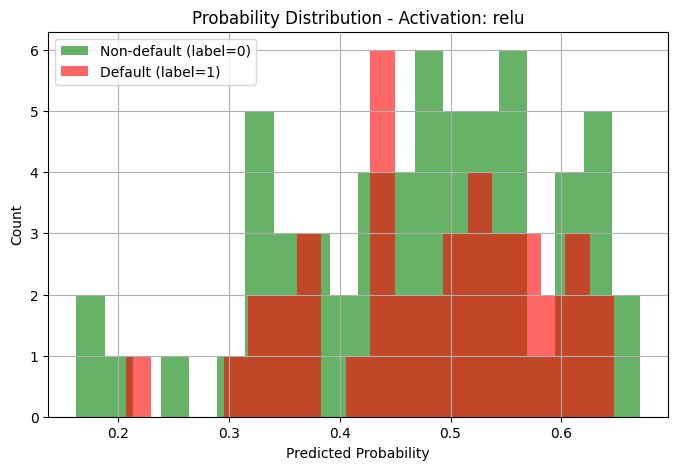


Plotting probability histogram for activation: leaky_relu


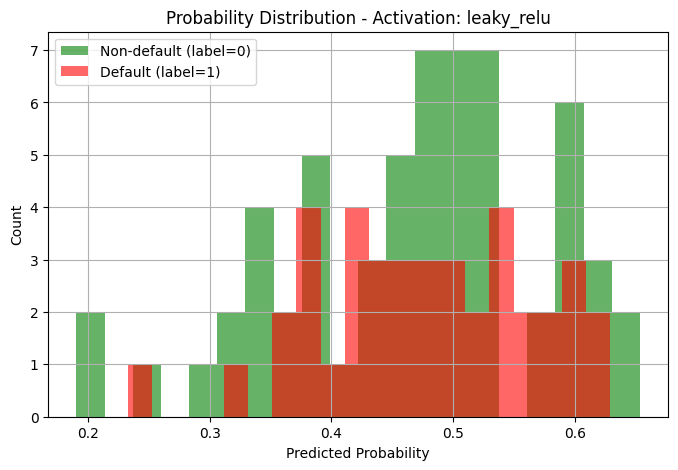

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# Probability of acquisition + label (universal, no restriction on activation function)
def get_probabilities(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)

            all_logits.append(logits.cpu())
            all_labels.append(yb)

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    # Convert logits → probabilities
    probs = 1 / (1 + np.exp(-logits))

    return probs, labels


# Plot the probability distribution histogram of a single activation function model
def plot_probability_histogram(model, loader, activation_name, device):
    probs, labels = get_probabilities(model, loader, device)

    probs_0 = probs[labels == 0]   # non-default
    probs_1 = probs[labels == 1]   # default

    plt.figure(figsize=(8, 5))

    plt.hist(probs_0, bins=20, alpha=0.6, label="Non-default (label=0)", color="green")
    plt.hist(probs_1, bins=20, alpha=0.6, label="Default (label=1)", color="red")

    plt.title(f"Probability Distribution - Activation: {activation_name}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()


# Function to draw 4 histograms at once
def plot_all_probability_histograms(models_dict, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for act, model in models_dict.items():
        print(f"\nPlotting probability histogram for activation: {act}")
        plot_probability_histogram(model, loader, act, device)


plot_all_probability_histograms(models, val_loader)
